In [1]:
import numpy as np
from scipy.interpolate import splprep, splev
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
orig_cmap = plt.get_cmap('Oranges')
new_cmap = mcolors.LinearSegmentedColormap.from_list("truncated", orig_cmap(np.linspace(0.2, 0.8, 256)))
import seaborn as sns
colors = sns.color_palette("pastel", 10)
from taskspec.method import estimate_measure, estimate_measure_weight
from taskspec.utils import find_project_root

In [2]:
N = 500
new_points = 20
np.random.seed(0)
means = [[0.5, 0.3], [0.8, 0.2], [0.6, 0.5], [0.8, 0.7], [0.9, 0.4]]
stds = [[0.2, 0.1], [0.18, 0.1], [0.18, 0.1], [0.18, 0.1], [0.18, 0.1]]
xdata = np.concatenate([
    np.random.normal(mean, std, (N, 2)) for mean, std in zip(means, stds)
], axis=0)
covs = [np.diag(np.array(std)**2) for std in stds]
pdfs = np.array([
    stats.multivariate_normal.pdf(xdata, mean=mean, cov=cov) 
    for mean, cov in zip(means, covs)
])
final_pdf = np.sum(pdfs, axis=0)

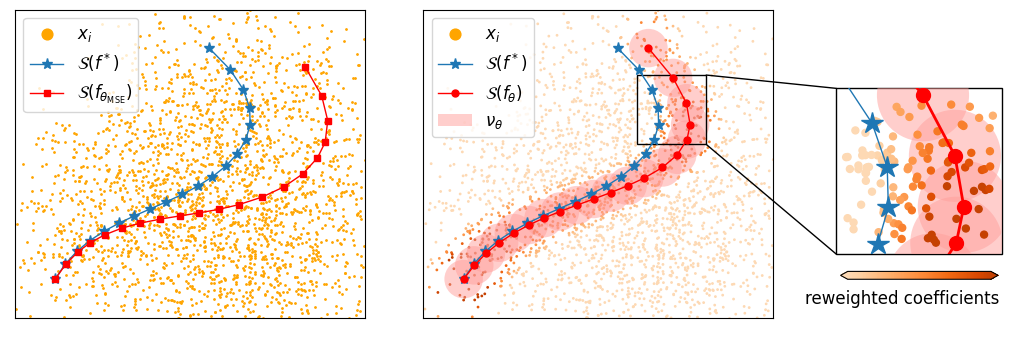

In [3]:
fig = plt.figure(figsize=(12.8, 4.))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1]) 
ax3 = fig.add_subplot(gs[2])

ind1 = np.all([xdata[:,0] >= 0.03, xdata[:,0] <= 1.2, xdata[:,1] >= 0.03, xdata[:,1] <= 0.93], axis=0)
ax1.scatter(-5, -5, alpha=1, s=60, color='orange', label=r'$x_i$')
ax1.scatter(xdata[ind1,0], xdata[ind1,1], alpha=1, s=1.0, color='orange')

ax1.axis('equal')
ax1.set_xlim(0.2, 1.1)  
ax1.set_xticks([])      
ax1.set_ylim(0.1, 0.9) 
ax1.set_yticks([])      

points0 = np.array([[0.3, 0.2], [0.39, 0.3], [0.7, 0.46], [0.75, 0.5], [0.7, 0.8]])
x0, y0 = points0[:, 0], points0[:, 1]
tck0, u0 = splprep([x0, y0], s=0)
u_new0 = np.linspace(0, 1, new_points)
x_new0, y_new0 = splev(u_new0, tck0)
ax1.plot(x_new0, y_new0, '-*', linewidth=1, markersize=8, label=r'$\mathcal{S}(f^*)$')

points1 = np.array([[0.3, 0.2], [0.4, 0.3], [0.72, 0.44], [0.83, 0.5], [0.78, 0.8]])
x1, y1 = points1[:, 0], points1[:, 1]
tck1, u1 = splprep([x1, y1], s=0)
u_new1 = np.array([0.0, 0.047, 0.094, 0.143, 0.194, 
                   0.243, 0.29, 0.34, 0.39, 0.44, 
                   0.49, 0.54, 0.59, 0.65, 0.71, 
                   0.77, 0.82, 0.88, 0.94, 1.])
x_new1, y_new1 = splev(u_new1, tck1)

points2 = np.array([[0.3, 0.2], [0.4, 0.3], [0.8, 0.4], [0.97, 0.5], [0.95, 0.75]])
x2, y2 = points2[:, 0], points2[:, 1]
tck2, u2 = splprep([x2, y2], s=0)
u_new2 = np.array([0.0, 0.043, 0.09, 0.13, 0.175, 
                   0.225, 0.275, 0.33, 0.38, 0.43, 
                   0.48, 0.53, 0.59, 0.65, 0.71, 
                   0.77, 0.82, 0.88, 0.94, 1.])
x_new2, y_new2 = splev(u_new2, tck2)
ax1.plot(x_new2, y_new2, '-s', linewidth=1, markersize=5,  color='red', label=r'$\mathcal{S}(f_{\theta_{\mathrm{MSE}}})$')

ax1.legend(fontsize=12)

new_sample = np.vstack([x_new1, y_new1]).T
rho_theta = estimate_measure(new_sample, new_sample, 0.005)  # rho is the new called measure
nu_train = estimate_measure_weight(xdata, new_sample, np.ones(shape=(new_sample.shape[0])), 0.005) # weighted loss
weights = nu_train / final_pdf

#####################

ax2.scatter(-5, -5, alpha=1, s=60, color='orange', label=r'$x_i$')
ax2.scatter(xdata[ind1,0], xdata[ind1,1], c=weights[ind1], alpha=1, s=1.0, cmap=new_cmap, vmin=0.1, vmax=0.5)

ax2.axis('equal')
ax2.set_xlim(0.2, 1.1)  
ax2.set_xticks([])      
ax2.set_ylim(0.1, 0.9) 
ax2.set_yticks([])      

ax2.plot(x_new0, y_new0, '-*', linewidth=1, markersize=8, label=r'$\mathcal{S}(f^*)$')
ax2.plot(x_new1, y_new1, '-o', linewidth=1, markersize=5, color='red', label=r'$\mathcal{S}(f_\theta)$')

circle = plt.Circle((-5, -5), 0.05, facecolor=colors[3], fill=True, alpha=0.5, label=r'$\nu_\theta$')
ax2.add_patch(circle)

for (x, y) in zip(x_new1, y_new1):
    circle = plt.Circle((x, y), 0.05, facecolor=colors[3], fill=True, alpha=0.5)
    ax2.add_patch(circle)

h = 0.18
xa, ya = 0.75, 0.55
rect = patches.Rectangle((xa, ya), h, h, linewidth=1, edgecolor='k', facecolor='none')
ax2.add_patch(rect)

ax2.legend(fontsize=12)

############
rect = patches.Rectangle((xa, ya), h, h, linewidth=1, edgecolor='k', facecolor='none', transform=ax3.transData)
ax3.add_patch(rect)

for (x, y) in zip(x_new1, y_new1):
    circle = plt.Circle((x, y), 0.05, facecolor=colors[3], fill=True, alpha=0.5)
    ax3.add_patch(circle).set_clip_path(rect)

ax3.axis('equal')
ax3.set_xlim(xa-0.005, xa+h+0.005)
ax3.set_xticks([])
ax3.set_ylim(ya-0.005, ya+h+0.005)
ax3.set_yticks([])

ax3.plot(x_new0, y_new0, '-*', linewidth=1, markersize=16, label=r'$\mathcal{S}(f^*)$')[0].set_clip_path(rect)
ax3.plot(x_new1, y_new1, '-o', linewidth=2, markersize=10, color='red', label=r'$\mathcal{S}(f_\theta)$')[0].set_clip_path(rect)

ind = np.all([xdata[:,0] <= xa+h-0.01, xdata[:,0] >= xa+0.01, xdata[:,1] <= ya+h-0.01, xdata[:,1] >= ya+0.01], axis=0)
sc = ax3.scatter(xdata[ind,0], xdata[ind,1], c=weights[ind], marker='o', alpha=1, s=25, cmap=new_cmap, vmin=0.1, vmax=0.5)

cbar = plt.colorbar(sc, ax=ax3, orientation="horizontal", shrink=0.9, extend="both", ticks=[], pad=-0.2)
cbar_label = cbar.ax.yaxis.label
cbar.ax.text(-0.3, -2.5, "reweighted coefficients", fontsize=12, ha="left", va="center", transform=cbar.ax.transAxes)

for spine in ax3.spines.values():
    spine.set_visible(False)

con = patches.ConnectionPatch(
    xyA=(xa+h, ya), coordsA=ax2.transData,  
    xyB=(xa, ya), coordsB=ax3.transData,  
    arrowstyle="-", color="black", linewidth=1
)
fig.add_artist(con) 

con = patches.ConnectionPatch(
    xyA=(xa+h, ya+h), coordsA=ax2.transData,  
    xyB=(xa, ya+h), coordsB=ax3.transData,  
    arrowstyle="-", color="black", linewidth=1
)
fig.add_artist(con) 

plt.savefig(find_project_root() + "/examples/fig/Eg0.pdf", format="pdf", bbox_inches="tight")
plt.show()